In [0]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
img_size = 512

loader = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = image.convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader('./guernica.png')
content_img = image_loader('./dany.png')

print(style_img.size())
print(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


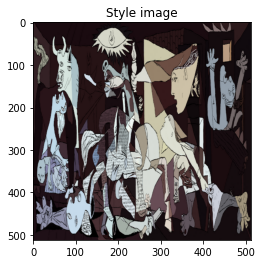

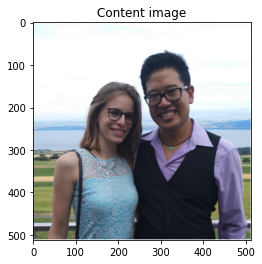

In [4]:
unloader = transforms.ToPILImage()

plt.ion()

def img_show(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
img_show(style_img, title='Style image')

plt.figure()
img_show(content_img, title='Content image')

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [0]:
def gram_matrix(input_):
    b, c, h, w = input_.size()

    features = input_.view(b*c, h*w)

    G = torch.mm(features, features.t())

    return G.div(b*c*h*w)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input_):
        G = gram_matrix(input_)
        self.loss = F.mse_loss(G, self.target)

        return input_

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):

    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    
    def forward(self, img):
        return (img - self.mean) / self.std

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean,
                                  normalization_std).to(device)
    
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')
        
        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i + 1)]

    return model, style_losses, content_losses


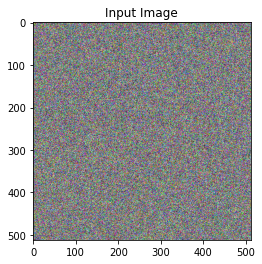

In [10]:
# input_img = content_img.clone()
input_img = torch.randn(content_img.data.size(), device=device)
plt.figure()
img_show(input_img, title='Input Image')


In [0]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss

            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f'run {run}:')
                print(f'Style Loss: {style_score.item():.4f},'\
                      f'Content Loss: {content_score.item()}')
                print()
                output = input_img.clone().detach()
                output = output.data.clamp_(0, 1)
                torchvision.utils.save_image(output,
                                             f'results/dany_guarnica{run[0]}.png',
                                             nrow=1)

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img    
            

In [13]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=15000)
plt.figure()
img_show(output, title='Output Image')
plt.ioff()
plt.show()

Building the style transfer model...
Optimizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


run [50]:
Style Loss: 1268.2310,Content Loss: 53.28153991699219

run [100]:
Style Loss: 437.8476,Content Loss: 53.123565673828125

run [150]:
Style Loss: 229.6759,Content Loss: 52.946327209472656

run [200]:
Style Loss: 157.0525,Content Loss: 52.75306701660156

run [250]:
Style Loss: 156.4225,Content Loss: 52.21095275878906

run [300]:
Style Loss: 89.7931,Content Loss: 51.98733901977539

run [350]:
Style Loss: 73.7871,Content Loss: 51.65830993652344

run [400]:
Style Loss: 61.4187,Content Loss: 51.16221237182617

run [450]:
Style Loss: 54.1057,Content Loss: 51.03705978393555

run [500]:
Style Loss: 42.1178,Content Loss: 50.35366439819336

run [550]:
Style Loss: 38.5629,Content Loss: 50.044227600097656

run [600]:
Style Loss: 52.1022,Content Loss: 49.245906829833984

run [650]:
Style Loss: 130.4795,Content Loss: 48.54393768310547

run [700]:
Style Loss: 20.6407,Content Loss: 48.31077194213867

run [750]:
Style Loss: 18.2607,Content Loss: 47.855812072753906

run [800]:
Style Loss: 16.449

KeyboardInterrupt: ignored

In [0]:
torchvision.utils.save_image(output, 'dany_dany2.png', nrow=1)